most of this project is inspired by this paper https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf so you can refer to it

In [61]:
import sys
sys.path.append('/home/aayushjoshi/ML/MLenv/lib/python3.11/site-packages')

In [62]:
import torch 
import torch.nn.functional as F 
import matplotlib.pyplot as plt
%matplotlib inline

In [63]:
words = open('names.txt','r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [64]:
len(words)

32033

In [65]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


building the dataset

In [66]:
block_size = 3 # number of characters we take to predict the next one
X, Y = [], []

for w in words[:5]:
    print(w)
    context = [0] * block_size
    for ch in w + '.' :
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        print(''.join(itos[i] for i in context), '---->', itos[ix])
        context = context[1:] + [ix]
    
X = torch.tensor(X)
Y = torch.tensor(Y)

emma
... ----> e
..e ----> m
.em ----> m
emm ----> a
mma ----> .
olivia
... ----> o
..o ----> l
.ol ----> i
oli ----> v
liv ----> i
ivi ----> a
via ----> .
ava
... ----> a
..a ----> v
.av ----> a
ava ----> .
isabella
... ----> i
..i ----> s
.is ----> a
isa ----> b
sab ----> e
abe ----> l
bel ----> l
ell ----> a
lla ----> .
sophia
... ----> s
..s ----> o
.so ----> p
sop ----> h
oph ----> i
phi ----> a
hia ----> .


we are gonna embed these input X in this loook up table C which is nothing bbut justs bunch of random numbers but we are gonna fine tune them with time 

In [67]:
C = torch.randn((27,2))

indexing in torch is very flexible because youcannot only index using numbers but we can also inde using lists or torchtensors

In [68]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [69]:
W1 = torch.randn((6,100))
b1 = torch.randn(100)


right now we cannot multiply W1 and emb here because they are of different shapes so we need to concatinate our emb into a 32,6 shape

In [70]:
torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], 1).shape # not generalized for block size so instead use below one

torch.Size([32, 6])

In [71]:
torch.cat(torch.unbind(emb, 1), 1).shape # it is unefficient and creates new memory

torch.Size([32, 6])

another quicker way is there to do this in torch

In [72]:
# a = torch.arange(18)
# a.shape
# a.view([3,2,3])
# a.storage() # data in a tensor is stored as a single dimenesional array and hence can be viewed as n dimensioanl array


so we can use tensor.view for this purpose and use it directly to multipy

In [73]:
h = torch.tanh(emb.view(-1,6) @ W1 + b1) # activation of layer 1 # the addition here is getting correcly broadcasted but make sure that happens all the time

In [74]:
W2 = torch.randn((100,27))
b2 = torch.randn(27)

In [75]:
logits = h @ W2 + b2
counts = logits.exp()
prob = counts / counts.sum(1,keepdims=True)

In [76]:
loss = -prob[torch.arange(32),Y].log().mean()
loss

tensor(19.6530)

these probabilites are really off right now so we will train our neural network to make these a bit better

In [77]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6,100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [78]:
sum(p.nelement() for p in parameters)
for p in parameters:
    p.requires_grad = True

In [79]:
for _ in range(1000):
    #forward pass
    emb = C[X]
    h = torch.tanh(emb.view(-1,6) @ W1 + b1)
    logits = h @ W2 + b2
    # counts = logits.exp() - 100 # should not use it because exp(100) and things like that would become infinite because floating point number runs out of space but for negative numbers such as exp(-100) it still is fine that's why pytorch subtracts a number from logits
    # prob = counts / counts.sum(1,keepdims=True)
    # loss = -prob[torch.arange(32),Y].log().mean()
    # instead directly use cross entropy loss
    loss = F.cross_entropy(logits, Y) # more efficient and doesnt creates extra memory
    

    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    for p in parameters:
        p.data += -0.1 * p.grad

print(loss.item())

0.2561509907245636


In [80]:
logits.max(1)

torch.return_types.max(
values=tensor([13.3437, 17.7879, 20.5832, 20.6042, 16.7390, 13.3437, 15.9747, 14.1889,
        15.9158, 18.3894, 15.9409, 20.9284, 13.3437, 17.1212, 17.1498, 20.0637,
        13.3437, 16.4564, 15.1328, 17.0537, 18.5905, 15.9655, 10.8739, 10.6874,
        15.5062, 13.3437, 16.2394, 16.9563, 12.7426, 16.2141, 19.0840, 16.0213],
       grad_fn=<MaxBackward0>),
indices=tensor([ 9, 13, 13,  1,  0,  9, 12,  9, 22,  9,  1,  0,  9, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0,  9, 15, 16,  8,  9,  1,  0]))

In [81]:
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

now we are taking all the words in input

## optimization

In [82]:
block_size = 3 # number of characters we take to predict the next one
X, Y = [], []

for w in words:
    context = [0] * block_size
    for ch in w + '.' :
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix]
    
X = torch.tensor(X)
Y = torch.tensor(Y)

In [94]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6,100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)


parameters = [C, W1, b1, W2, b2]
sum(p.nelement() for p in parameters)


for p in parameters:
    p.requires_grad = True

In [84]:
for _ in range(10):
    #forward pass
    emb = C[X]
    h = torch.tanh(emb.view(-1,6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y) 
    print(loss.item())
    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    for p in parameters:
        p.data += -0.1 * p.grad

19.505226135253906
17.08448600769043
15.776531219482422
14.833340644836426
14.002605438232422
13.253263473510742
12.57991886138916
11.983102798461914
11.47049331665039
11.05185604095459


this is gonna take too long for all the example so we gonna do mini batch gradient decent

In [85]:
for _ in range(100):
    #mini batch construct
    ix = torch.randint(0, X.shape[0], (32,))

    #forward pass
    emb = C[X[ix]]
    h = torch.tanh(emb.view(-1,6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix]) 
    # print(loss.item())
    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    for p in parameters:
        p.data += -0.1 * p.grad

now we want to optimize our learning rate and to do so we know by checking that our learning rate must be in bw -1 and -0.001

In [91]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre
lrs # we are using this way so that we are not linearly stepping the learning rate instead we linearly stepping the exponents

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0014,
        0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014,
        0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
        0.0015, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016,
        0.0016, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017,
        0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0021, 0.0021, 0.0021, 0.0021,
        0.0021, 0.0021, 0.0021, 0.0022, 

this learing rate is going to be 0.001 in the beginning but by the end it will become 1

In [92]:
lri = []
lossi = []

for i in range(1000):
    #mini batch construct
    ix = torch.randint(0, X.shape[0], (32,))

    #forward pass
    emb = C[X[ix]]
    h = torch.tanh(emb.view(-1,6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix]) 
    # print(loss.item())

    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    lr = lrs[i]
    for p in parameters:
        p.data += -lr * p.grad

    #track stats
    lri.append(lre[i])
    lossi.append(loss.item()) 

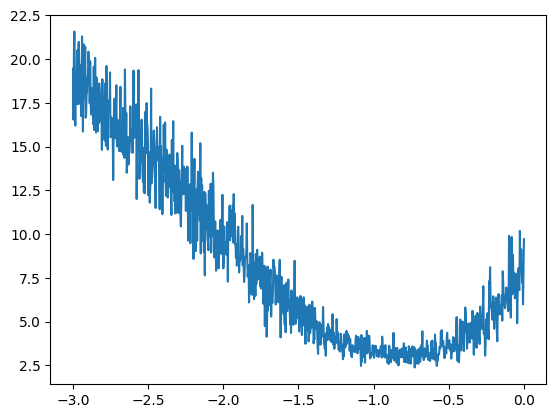

In [93]:
plt.plot(lri, lossi)

the points in the valley seem like good points to use which is 10**-1 so now we are confident in our choice of alpha 

In [97]:
for i in range(10000):
    #mini batch construct
    ix = torch.randint(0, X.shape[0], (32,))

    #forward pass
    emb = C[X[ix]]
    h = torch.tanh(emb.view(-1,6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix]) 
    # print(loss.item())

    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad

In [98]:
emb = C[X]
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y) 
loss

tensor(2.5103, grad_fn=<NllLossBackward0>)

we are already at lower loss than the last bigram model<br>but honestly we are overfitting which means the model wont work that nicely on any data other than our training set<br>
so it is a better idea to create train/dev/test split

In [99]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words)) # 80%
n2 = int(0.9*len(words)) # 90%

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [100]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6,100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)


parameters = [C, W1, b1, W2, b2]
sum(p.nelement() for p in parameters)


for p in parameters:
    p.requires_grad = True

In [101]:
for i in range(10000):
    #mini batch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))

    #forward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1,6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix]) 
    # print(loss.item())

    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad

In [102]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev) 
loss

tensor(2.5632, grad_fn=<NllLossBackward0>)

In [103]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr) 
loss

tensor(2.5694, grad_fn=<NllLossBackward0>)

we can see that the loss is almost same for the train and dev set this means that we are underfitting the data and it means that are network is very small so we gonna increase the size of neural network

In [104]:
# increasing the number of neurons
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6,300), generator=g)
b1 = torch.randn(300, generator=g)
W2 = torch.randn((300, 27), generator=g)
b2 = torch.randn(27, generator=g)


parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))


for p in parameters:
    p.requires_grad = True

10281


In [105]:
lri = []
lossi = []
stepi = []

for i in range(30000):
    #mini batch construct
    ix = torch.randint(0, X.shape[0], (32,))

    #forward pass
    emb = C[X[ix]]
    h = torch.tanh(emb.view(-1,6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix]) 
    # print(loss.item())

    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    lr = 0.1
    for p in parameters:
        p.data += -lr * p.grad

    #track stats
    # lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.item()) 

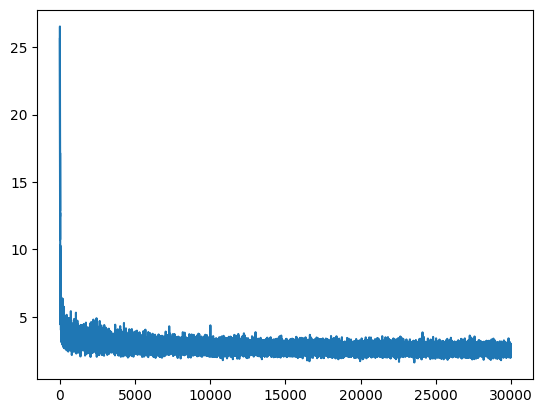

In [106]:
plt.plot(stepi, lossi)

In [108]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev) 
loss

tensor(2.5280, grad_fn=<NllLossBackward0>)

still things can be improved 

there seems to be a bottleneck in our embedding because providing a lot of data but it is very small<br>idk how to explain it properly

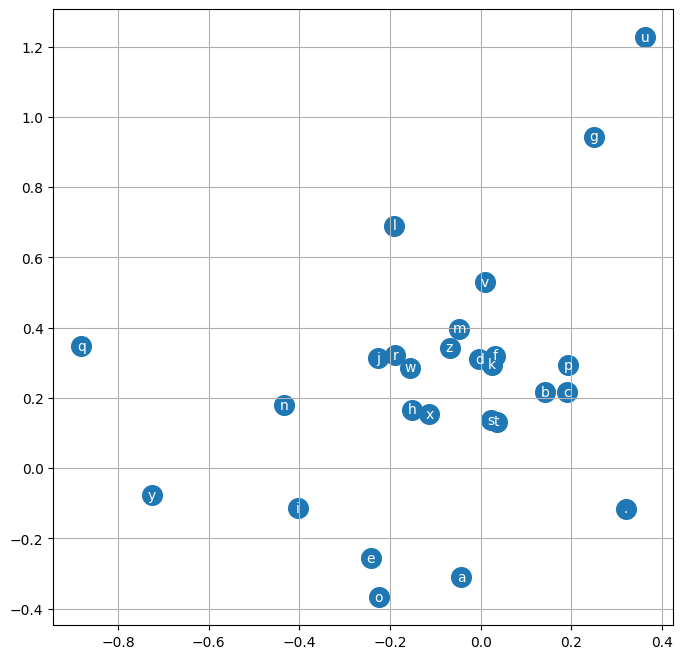

In [109]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

we can see how some letters are clustered up really close by and some are really far away like q letter so like all the characters that are together quite replacable with each other

so we increased the size of our hidden layer and it didnt seem to improve our model so this must mean that there is a bottleneck in the embedding so we are gonna increase hte shape of that as well

In [151]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g) # increasing the number of em bedding from 2 to 10
W1 = torch.randn((30,200), generator=g)
b1 = torch.randn(200, generator=g) # decreased the size of hidden layer as well
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))


for p in parameters:
    p.requires_grad = True

11897


In [152]:
lri = []
lossi = []
stepi = []

In [146]:
for i in range(50000):
    #mini batch construct
    ix = torch.randint(0, X.shape[0], (32,))

    #forward pass
    emb = C[X[ix]]
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # should not hardcode this argument for view because in production its not a very good idea
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix]) 
    # print(loss.item())

    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    lr = 0.1
    for p in parameters:
        p.data += -lr * p.grad

    #track stats
    # lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item()) # gonna plot log loss so that we have a better shape

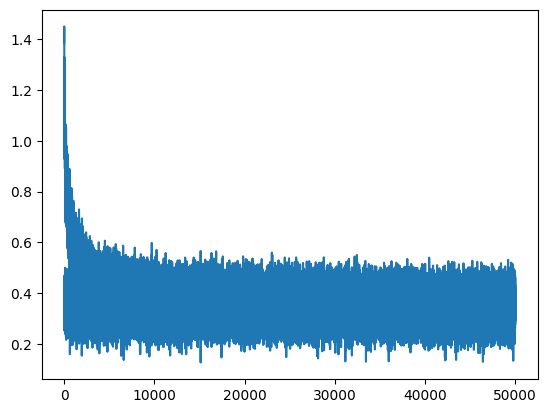

In [147]:
plt.plot(stepi, lossi)

In [148]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1,30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr) 
loss

tensor(2.2712, grad_fn=<NllLossBackward0>)

In [149]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1,30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev) 
loss

tensor(2.2595, grad_fn=<NllLossBackward0>)

we can see how our train and dev set loss are seperating so it is s good sign<br>but while doing this in practice we set multiple hyperparameters and then fine tune them on our dev set and at last when we want to report our results in a paper or somewhere we report the test set loss

updated code

In [153]:
for i in range(200000):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))
  
  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 10)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 200)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

#print(loss.item())

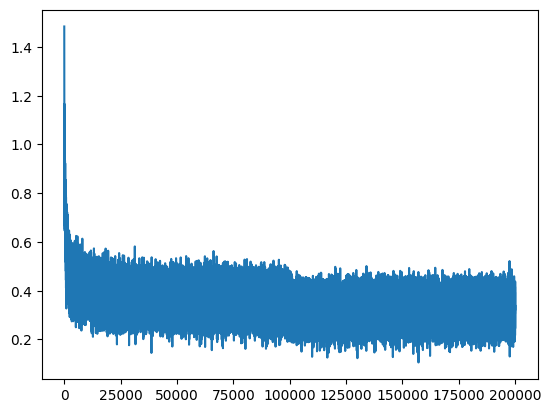

In [154]:
plt.plot(stepi, lossi)

In [155]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1,30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr) 
loss

tensor(2.1310, grad_fn=<NllLossBackward0>)

In [156]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1,30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev) 
loss

tensor(2.1658, grad_fn=<NllLossBackward0>)

now we can still improve this model by fine tuning more of te hyperparameters

In [157]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

mora.
mayan.
see.
med.
rylle.
emmastendra.
gra.
chedrelin.
shi.
jen.
eden.
van.
nar.
katelos.
kalin.
shdyn.
gian.
jest.
jair.
jelinxe.
